# Линейная регрессия
__Суммарное количество баллов: 10__


In [59]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas

In [4]:
def read_data(path="./hw8_data/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [2]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Ее и нужно реализовать.

In [3]:
def mse(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [157]:
class NormalLR:
    def fit(self, X, y):
        x = self.extend(X)
        xt_x_inv = np.linalg.inv(np.dot(x.T, x))
        xt_y = np.dot(x.T, y)
        self.w = np.dot(xt_x_inv, xt_y)
    
    def predict(self, X):
        return np.dot(self.extend(X), self.w)
    
    def extend(self, X):
        x = np.array(X)
        ones = list(map(lambda _: 1, x))
        return np.insert(x, 0, ones, axis=1)

In [137]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [138]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.010245402210613978


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

### Задание 4 (2 балла)
Добавьте в метод `fit` регуляризацию Лассо с коэффициентом `l`. Постройте график зависимости ошибки предсказания данных из синтетического набора данных от коэффициента регуляризации.

In [227]:
class GradientLR():
    def __init__(self, alpha, iterations=10000, l=0., scale=False, binary=False):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.scale = scale
        self.binary = binary
    
    def fit(self, X, y):
        n_features = X.shape[1]
        n_rows = X.shape[0]
        x = self.extend(X)
        xt = x.T
        self.w = np.zeros(n_features+1)
        penalty = np.zeros(n_features+1) + self.l
        penalty[0] = 0
        for _ in range(self.iterations):
            yp = np.dot(x, self.w)
            err = y - yp
            dw = -2*np.dot(xt/n_rows, err) - np.sign(self.w)*penalty/n_rows
            self.w = self.w - self.alpha * dw

    def extend(self, X):
        x = np.array(X)
        if self.scale:
            x = np.array(list(map(lambda column: column/np.max(column), x.T))).T
        ones = list(map(lambda _: 1, x))
        return np.insert(x, 0, ones, axis=1)
    
    def predict(self, X):
        yp = np.dot(self.extend(X), self.w)
        return 1*(yp > 0.5) if self.binary else yp

In [206]:
def build_plot(X_train, y_train, X_test, y_test, ls, make_regr):
    def calc_mse(l):
        regr = make_regr(l)
        regr.fit(X_train, y_train)
        return mse(y_test, regr.predict(X_test))
    mses = list(map(calc_mse, ls))
    plt.plot(ls, mses)
    plt.xlabel('коэффициент регуляризации')
    plt.ylabel('MSE')
    plt.show()

In [228]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

0.008131786656114953


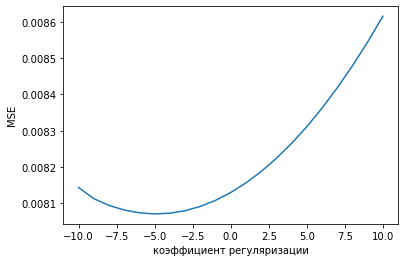

In [229]:
regr = GradientLR(0.1, iterations=10000, l=0.1)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test, list(range(-10, 11)), lambda l: GradientLR(0.1, l=l))

### Задание 5 (2 балла)
Протесируйте оба метода на данных cancer и spam, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [238]:
df = pandas.read_csv('hw8_data/cancer.csv')
X = df.drop(['label'], axis=1)
y = df['label'].apply(lambda t: 1 if t == 'M' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [153]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_class = 1*(y_pred > 0.5)
print(mse(y_test, y_class))

0.02631578947368421


0.017543859649122806


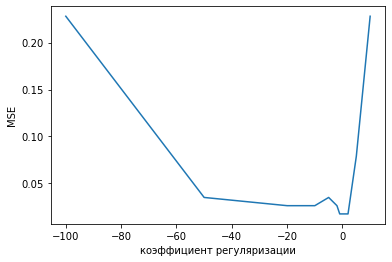

In [239]:
regr = GradientLR(0.002, iterations=10000, scale=True, binary=True)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
ls = [-100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10]
build_plot(X_train, y_train, X_test, y_test, ls, lambda l: GradientLR(0.002, l=l, scale=True, binary=True))

In [252]:
df = pandas.read_csv('hw8_data/spam.csv')
X = df.drop(['label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [253]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_class = 1*(y_pred > 0.5)
print(mse(y_test, y_class))

0.10097719869706841


In [ ]:
regr = GradientLR(0.1, iterations=10000, scale=True, binary=True)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

In [ ]:
build_plot(X_train, y_train, X_test, y_test, list(range(-10, 11)), lambda l: GradientLR(0.1, l=l, scale=True, binary=True))